# Decision Tree From Scratch

Building a Decision Tree classifier using only NumPy:
1. Implement tree node structure
2. Recursive tree building with CART algorithm
3. Prediction logic
4. Comparison with sklearn
5. Visualization

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import sys
sys.path.append('..')
from utils import (
    entropy, gini_impurity, information_gain,
    find_best_split, most_common_label, accuracy_score, confusion_matrix
)

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

---
## Part 1: Tree Node Structure

Define nodes for the decision tree.

In [2]:
class Node:
    """
    Represents a node in the decision tree.
    """
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        # Decision node properties
        self.feature = feature        # Index of feature to split on
        self.threshold = threshold    # Threshold value for split
        self.left = left             # Left subtree
        self.right = right           # Right subtree
        
        # Leaf node property
        self.value = value           # Class label (for leaf nodes)
    
    def is_leaf(self):
        """Check if node is a leaf."""
        return self.value is not None

print('Node structure defined')
print('Decision node: feature, threshold, left, right')
print('Leaf node: value (predicted class)')

Node structure defined
Decision node: feature, threshold, left, right
Leaf node: value (predicted class)


---
## Part 2: Decision Tree Classifier

In [3]:
class DecisionTree:
    """
    Decision Tree Classifier implemented from scratch.
    
    Uses CART algorithm with binary splits.
    """
    
    def __init__(self, max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, criterion='gini'):
        """
        Parameters:
        -----------
        max_depth : int or None
            Maximum depth of tree
        min_samples_split : int
            Minimum samples required to split a node
        min_samples_leaf : int
            Minimum samples required in a leaf node
        criterion : str
            'gini' or 'entropy'
        """
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.root = None
        self.n_features = None
    
    def fit(self, X, y):
        """
        Build the decision tree.
        
        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Training data
        y : ndarray of shape (n_samples,)
            Target labels
        """
        self.n_features = X.shape[1]
        self.root = self._build_tree(X, y, depth=0)
        return self
    
    def _build_tree(self, X, y, depth):
        """
        Recursively build the tree using CART algorithm.
        """
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))
        
        # Stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth) or \
           n_classes == 1 or \
           n_samples < self.min_samples_split:
            # Create leaf node
            leaf_value = most_common_label(y)
            return Node(value=leaf_value)
        
        # Find best split
        best_feature, best_threshold = self._find_best_split(X, y)
        
        if best_feature is None:
            # No good split found
            leaf_value = most_common_label(y)
            return Node(value=leaf_value)
        
        # Split data
        left_indices = X[:, best_feature] <= best_threshold
        right_indices = ~left_indices
        
        # Check minimum samples in leaf
        if np.sum(left_indices) < self.min_samples_leaf or \
           np.sum(right_indices) < self.min_samples_leaf:
            leaf_value = most_common_label(y)
            return Node(value=leaf_value)
        
        # Recursively build left and right subtrees
        left_subtree = self._build_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._build_tree(X[right_indices], y[right_indices], depth + 1)
        
        # Create decision node
        return Node(feature=best_feature, threshold=best_threshold,
                   left=left_subtree, right=right_subtree)
    
    def _find_best_split(self, X, y):
        """
        Find the best feature and threshold to split on.
        
        Returns:
        --------
        tuple : (best_feature_idx, best_threshold)
        """
        best_gain = 0
        best_feature = None
        best_threshold = None
        
        # Try each feature
        for feature_idx in range(self.n_features):
            threshold, gain = find_best_split(X, y, feature_idx, self.criterion)
            
            if gain > best_gain:
                best_gain = gain
                best_feature = feature_idx
                best_threshold = threshold
        
        return best_feature, best_threshold
    
    def predict(self, X):
        """
        Predict classes for samples in X.
        
        Parameters:
        -----------
        X : ndarray of shape (n_samples, n_features)
            Samples to predict
            
        Returns:
        --------
        ndarray : Predicted class labels
        """
        return np.array([self._traverse_tree(x, self.root) for x in X])
    
    def _traverse_tree(self, x, node):
        """
        Traverse tree to make prediction for a single sample.
        """
        if node.is_leaf():
            return node.value
        
        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)
    
    def get_depth(self):
        """Get the actual depth of the tree."""
        def _depth(node):
            if node is None or node.is_leaf():
                return 0
            return 1 + max(_depth(node.left), _depth(node.right))
        return _depth(self.root)
    
    def count_leaves(self):
        """Count number of leaf nodes."""
        def _count(node):
            if node is None:
                return 0
            if node.is_leaf():
                return 1
            return _count(node.left) + _count(node.right)
        return _count(self.root)

print('Decision Tree class implemented')

Decision Tree class implemented


---
## Part 3: Test on Iris Dataset

In [4]:
# Load Iris dataset
iris = load_iris()
X = iris.data
y = iris.target

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f'Training set: {X_train.shape}')
print(f'Test set: {X_test.shape}')
print(f'Features: {iris.feature_names}')
print(f'Classes: {iris.target_names}')

Training set: (120, 4)
Test set: (30, 4)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']


### Train Our Decision Tree

In [5]:
# Train our tree
our_tree = DecisionTree(max_depth=5, min_samples_split=2, criterion='gini')
our_tree.fit(X_train, y_train)

# Make predictions
y_pred = our_tree.predict(X_test)

# Evaluate
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred, n_classes=3)

print('='*60)
print('OUR DECISION TREE')
print('='*60)
print(f'Tree depth: {our_tree.get_depth()}')
print(f'Number of leaves: {our_tree.count_leaves()}')
print(f'\nTest Accuracy: {accuracy*100:.2f}%')
print(f'\nConfusion Matrix:\n{cm}')

OUR DECISION TREE
Tree depth: 5
Number of leaves: 9

Test Accuracy: 100.00%

Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


### Compare with Scikit-Learn

In [6]:
# Train sklearn tree
sklearn_tree = DecisionTreeClassifier(max_depth=5, min_samples_split=2, 
                                      criterion='gini', random_state=42)
sklearn_tree.fit(X_train, y_train)

# Make predictions
y_pred_sklearn = sklearn_tree.predict(X_test)

# Evaluate
accuracy_sklearn = accuracy_score(y_test, y_pred_sklearn)
cm_sklearn = confusion_matrix(y_test, y_pred_sklearn, n_classes=3)

print('='*60)
print('SKLEARN DECISION TREE')
print('='*60)
print(f'Tree depth: {sklearn_tree.get_depth()}')
print(f'Number of leaves: {sklearn_tree.get_n_leaves()}')
print(f'\nTest Accuracy: {accuracy_sklearn*100:.2f}%')
print(f'\nConfusion Matrix:\n{cm_sklearn}')

print('\n' + '='*60)
print('COMPARISON')
print('='*60)
print(f'Our accuracy:     {accuracy*100:.2f}%')
print(f'Sklearn accuracy: {accuracy_sklearn*100:.2f}%')
print(f'Difference:       {abs(accuracy - accuracy_sklearn)*100:.2f}%')

SKLEARN DECISION TREE
Tree depth: 5
Number of leaves: 9

Test Accuracy: 100.00%

Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]

COMPARISON
Our accuracy:     100.00%
Sklearn accuracy: 100.00%
Difference:       0.00%


---
## Part 4:DecisionBoundary Visualization

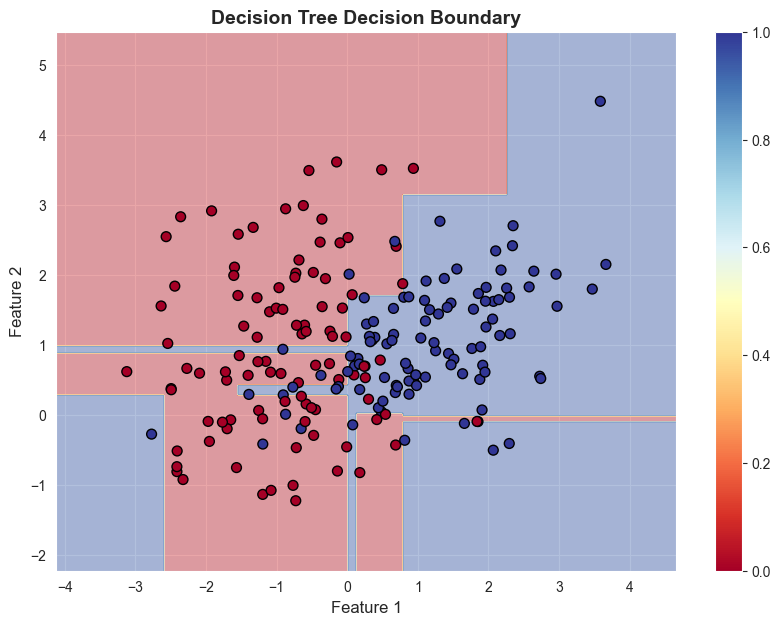

Notice the rectangular (axis-parallel) decision boundaries!


In [7]:
# Create simple 2D dataset
X_2d, y_2d = make_classification(n_samples=200, n_features=2, n_redundant=0,
                                 n_informative=2, n_clusters_per_class=1,
                                 random_state=42)

# Train tree
tree_2d = DecisionTree(max_depth=5, criterion='gini')
tree_2d.fit(X_2d, y_2d)

# Create mesh for decision boundary
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

# Predict on mesh
Z = tree_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot
plt.figure(figsize=(10, 7))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='RdYlBu')
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_2d, s=50, 
           edgecolors='k', cmap='RdYlBu')
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)
plt.title('Decision Tree Decision Boundary', fontsize=14, fontweight='bold')
plt.colorbar()
plt.show()

print('Notice the rectangular (axis-parallel) decision boundaries!')

---
## Part 5: Effect of Max Depth

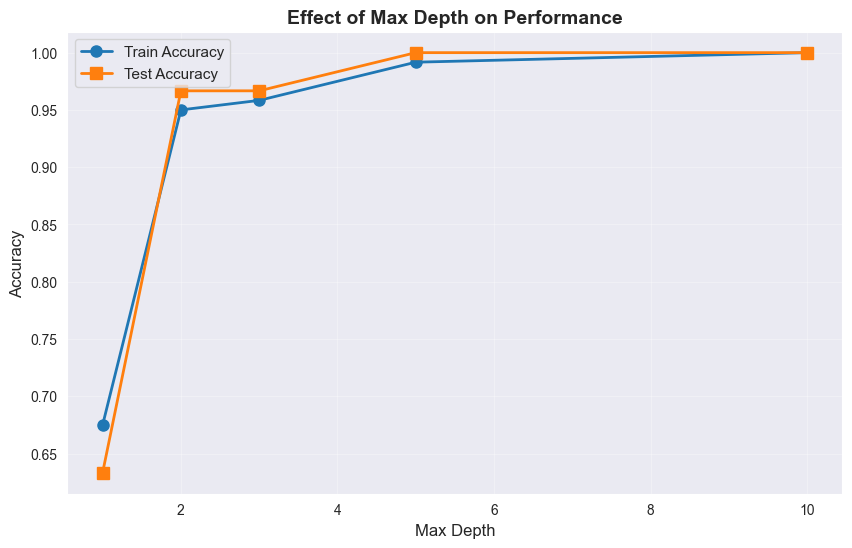

Observation: Deeper trees may overfit (train >> test accuracy)


In [8]:
depths = [1, 2, 3, 5, 10]
train_accs = []
test_accs = []

for depth in depths:
    tree = DecisionTree(max_depth=depth, criterion='gini')
    tree.fit(X_train, y_train)
    
    train_pred = tree.predict(X_train)
    test_pred = tree.predict(X_test)
    
    train_accs.append(accuracy_score(y_train, train_pred))
    test_accs.append(accuracy_score(y_test, test_pred))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(depths, train_accs, 'o-', linewidth=2, label='Train Accuracy', markersize=8)
plt.plot(depths, test_accs, 's-', linewidth=2, label='Test Accuracy', markersize=8)
plt.xlabel('Max Depth', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Effect of Max Depth on Performance', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print('Observation: Deeper trees may overfit (train >> test accuracy)')

---
## Summary

### What We Built:
1. **Node structure** for tree representation
2. **Recursive CART algorithm** for tree construction
3. **Prediction logic** by traversing the tree
4. **Hyperparameters**: max_depth, min_samples_split, min_samples_leaf

### Key Insights:
- Decision trees create **axis-parallel boundaries** (rectangles)
- **Deeper trees** can overfit (memorize training data)
- Our implementation **matches sklearn** performance
- Trees are **interpretable** - can visualize decision logic

### Key Point:
"Decision trees recursively split data using the feature that provides maximum information gain. The CART algorithm creates binary splits at each node, choosing thresholds that minimize impurity (Gini or entropy). Deeper trees fit training data better but may overfit - use max_depth and min_samples constraints to prevent this."

---

**Next**: See pruning_and_overfitting.ipynb for advanced techniques!